<a href="https://colab.research.google.com/github/cihan53/karakter_frekans/blob/main/sayisal_video_isleme_odev_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bu ödevde gri bir resimdeki parazitleri alçak geçirgen filtre kullanarak temizlemeniz istenmektedir.

* Görüntü dosyasının okunması: Görüntü dosyası “pgm” formatındadır. Bu formatı çözerek, görüntüyü bir matrise yerleştiriniz.
*  Alçak geçirgen filtre uygulanması: Görüntüye ortalama filtresi ve medyan filtresi uygulayan iki ayrı modül yazınız.
* Filtrelenmiş görüntülerin pgm formatında dosyaya yazılması: Filtreleme işlemi sonucunda elde ettiğiniz görüntüleri “pgm” formatında yeni bir dosyaya yerleştiren modülü yazınız.

In [40]:
# The standard way to import NumPy:
import numpy as np
from numpy import array, int32
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')


FILE_NAME=["balloonsNpgm.pgm","galaxy.pgm","glassN.pgm","lenaN.pgm"]



#
# portable graymap file format (PGM)
# Portable GrayMap 	P2 	P5 	.pgm 	0–255 (gray scale), 0–65535 (gray scale), variable, black-to-white range  
# 
# PGM example
#   The PGM and PPM formats (both ASCII and binary versions) have an additional parameter for the maximum value 
#   (numbers of grey between black and white) after the X and Y dimensions and before the actual pixel data. 
#   Black is 0 and max value is white. There is a newline character at the end of each line. 
# 
#  P2
#  Shows the word "FEEP" (example from Netpbm man page on PGM)
#  24 7
#  15
#  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
#  0  3  3  3  3  0  0  7  7  7  7  0  0 11 11 11 11  0  0 15 15 15 15  0
#  0  3  0  0  0  0  0  7  0  0  0  0  0 11  0  0  0  0  0 15  0  0 15  0
#  0  3  3  3  0  0  0  7  7  7  0  0  0 11 11 11  0  0  0 15 15 15 15  0
#  0  3  0  0  0  0  0  7  0  0  0  0  0 11  0  0  0  0  0 15  0  0  0  0
#  0  3  0  0  0  0  0  7  7  7  7  0  0 11 11 11 11  0  0 15  0  0  0  0
#  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
#
# (WikiPedia) https://en.wikipedia.org/wiki/Netpbm#File_formats

#pgm reader , header bilgileri kullanılarak genişlik yükseklik bulunuyor.
def pgmread(filepath):
    with open(filepath, 'rb') as f:
        # Read header information
        count = 0
        while count < 3:
            line = f.readline()
            if chr(line[0]) == '#':  # yorum satırlarını sil
                continue
            count = count + 1
            if count == 1:  # Magic num info
                magicNum = line.strip().decode("utf-8")
                if magicNum != 'P2' and magicNum != 'P5':
                    f.close()
                    print('Hatali PGM file')
                    exit()
            elif count == 2:  # Width and Height
                [width, height] = (line.strip()).split()
                width = int(width)
                height = int(height)
            elif count == 3:  # Max gray level
                maxVal = int(line.strip())
        # Read pixels information
        img = []
        buf = f.read()
        elem = buf.split()
        if magicNum == 'P2' and len(elem) != width * height:
            print('pixel sayisi hatali')
            exit()
        elif magicNum == 'P5' and len(buf) != width * height:
            print('pixel sayisi hatali')
            exit()

        index=0
        for i in range(height):
            tmpList = []
            for j in range(width):
                if magicNum == 'P5':
                    int_val = buf[index]
                    # int_val = int.from_bytes(byte_val, "little")
                    tmpList.append(int_val)
                    index+=1
                elif magicNum == 'P2':
                    tmpList.append(int(elem[i * width + j]))
            img.append(tmpList)

    return (np.array(img).astype("uint8"), (height,width),maxVal)



def pgmwrite(img, filename, maxVal=255, magicNum='P2'):
  """ Pgm version P2 , gri seviyesi 255 varsayılan olarak ayarlanmıştır.
  satir 1 : versiyon
  satir 2 : Width Height
  satir 3 : gri seviyesi
  Image Satir 1
  Image Satir 2 ... """
  img = int32(img).tolist()
  f = open(filename,'w')
  width = 0
  height = 0
  for row in img:
    height = height + 1
    width = len(row)
  f.write(magicNum + '\n')
  f.write(str(width) + ' ' + str(height) + '\n')
  f.write(str(maxVal) + '\n')
  for i in range(height):
    count = 1
    for j in range(width):
      f.write(str(img[i][j]) + ' ')
      if count >= 17:
        # maksimum 70 karakter (17*4=68)
        # maksimum karaktere ulaşınca yeni satır eklendi
        count = 1
        f.write('\n')
      else:
        count = count + 1
    f.write('\n')
  f.close()   

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Median ve Smooting (Averaging) flitreleme fonksiyonları
  ## Ortalama filtresi
  Birkaç farklı isimi vardır, ensık kullanılanları Mean filterin(Ortalama filtresi), Smooting(yumuşatma), Averaging(ortalama) , Box filtering(kutu filtresi)

  Ortalama filtre; bir pikselin değerini diğer piksellerin değişim miktarı ile azaltmaktır.\
  Ortalama filtre; görüntüdeki her bir pikselin komşularının ve kendisinin ortalaması ile değeri değişmektedir. Bu şekilde     çevresindekiler ile uyumsuz olan piksellerin değerlerinin ortadan kalması sağlanır.\
  Ortalama filtre, bir evrişimi işlemidir, bir fonksiyonun şeklinin başka bir fonksiyon tarafından nasıl değiştirildiğini gösterir ( Konvolüsyon ) \
  Kaynak : https://tr.wikipedia.org/wiki/Konvol%C3%BCsyon

  Ortalam filrenin bazı ana sorunları vardır.
   * Görüntüyü temsil etmeyan pikseller yakın bölgedeki piksellerin değerinin değişmesine neden olmaktadadır. Bu görüntünü bozulmasına neden olur.
   * Kenarlarda bulanıklaşmaya neden olur, kenar piksellerde ortalamaya katılan piksel olmadığından değişim oranı yüksek olmasına neden olacaktır.

   Aşağıda ki örneklerde her bir resime 3x3, 5x5, 7x7 maske ( kernel ) kullanarak ortalama filtre uygulanmıştır.

 ## Median filtre
  Bu filtrenin yaygın olan isimleri; Medyan filtresi (Orta Değer filtresi) (Median filtering), Sıralama filtresi (Rank filtering)

  Median filtresi, Averaging filtresi gibi görüntüdeki parazitleri(gürültü) azatlamak için kullanılır. Median filtresi görüntüdeki detayların kaybolmaması nedeni ile Averaging filtresinden çok daha iyi sonuçlar vermektedir.

  Temel olarak median filtresi sıralama işlemi yapmaktadır. Görüntüdeki her bir pikselin komşu (kernel kullanarak) piksellerini küçükten büyüğe sıralama yapar ve ortasındaki değeri alıp pikselin değerin değiştirir. Eğer incelenen kernel bölgesindeki piksel sayısı çift ise, orta değer olarak ortada bulunan iki pikselin ortalaması alınır.



In [21]:
# ortalama filitresi uygula

def smooting_filter(image, width, height, kernel_size=3):
    # yeni bir image oluştur
    img_new = np.zeros([height, width],dtype="uint8")

    k = int((kernel_size - 1) / 2)
    for x in range(k, (width - k) - 1):
        for y in range(k, (height - k) - 1):
            toplam = 0
            for i in range(-(k), k):
                for j in range(-(k), k):
                    toplam = toplam + image[y + i, x + j]

            img_new[y, x] = toplam / (kernel_size * kernel_size)

    return img_new.astype(np.uint8)

# median filitresi uygula
def median_filter(image, width, height, kernel_size=3):
    # yeni bir image oluştur
    img_new = np.zeros([height, width],dtype="uint8")
    k = int((kernel_size - 1) / 2)
    size_item = (kernel_size * kernel_size)
    tmp = [0] * size_item
    for x in range(k, (width - k) - 1):
        for y in range(k, (height - k) - 1):
            item = 0
            for i in range(-(k), k):
                for j in range(-(k), k):
                    tmp[item] = image[y + i, x + j]
                    item += 1

            tmp = sorted(tmp)
            img_new[y, x] = tmp[int(item / 2)]

    return img_new.astype(np.uint8)



Read file  galaxy.pgm


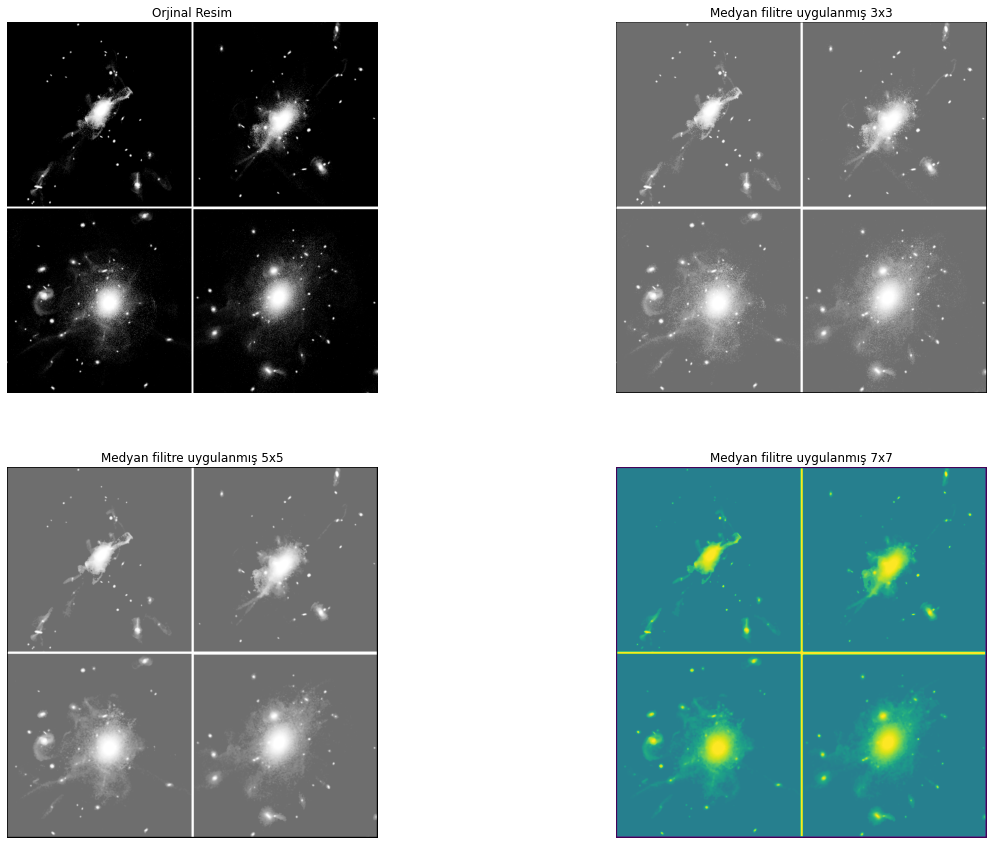

In [42]:
  # tablo oluşturmak için
rows = 2
columns = 2


  # resim okunup matris haline getiriliyor
for file_name in FILE_NAME:
    # resim okunup matris haline getiriliyor
    print("Read file ", file_name)
    (im, (height, width), gray) = pgmread('/content/gdrive/MyDrive/Yuksek_Lisans/Sayisal_video_isleme/images/' + file_name)
    fig = plt.figure(figsize=(20, 15))
    fig.add_subplot(rows, columns, 1 )
    plt.axis('off')
    plt.imshow(im  , cmap='gray' )
    plt.title('Orjinal Resim')

    
    #  Averaging
    
    copy_image_shape = im
    im1_mean = smooting_filter(copy_image_shape, width, height, 3)
    fig.add_subplot(rows, columns, 2 )
    plt.imshow(im1_mean,cmap='gray')
    plt.axis('off')
    plt.title("Ortalma filitre uygulanmış 3x3")
    #yeni dosyaya kayıt et
    pgmwrite(im1_mean,'/content/gdrive/MyDrive/Yuksek_Lisans/Sayisal_video_isleme/images/averaging_3x3_'+ file_name)

    im1_mean = smooting_filter(copy_image_shape, width, height, 5)
    fig.add_subplot(rows, columns, 3 )
    plt.imshow(im1_mean, cmap='gray')
    plt.axis('off')
    plt.title("Ortalma filitre uygulanmış 5x5")
    #yeni dosyaya kayıt et
    pgmwrite(im1_mean,'/content/gdrive/MyDrive/Yuksek_Lisans/Sayisal_video_isleme/images/averaging_5x5_'+ file_name)

    im1_mean = smooting_filter(copy_image_shape, width, height, 7)
    fig.add_subplot(rows, columns, 4 )
    plt.imshow(im1_mean, cmap='gray')
    plt.axis('off')
    plt.title("Ortalma filitre uygulanmış 7x7")
    #yeni dosyaya kayıt et
    pgmwrite(im1_mean,'/content/gdrive/MyDrive/Yuksek_Lisans/Sayisal_video_isleme/images/averaging_7x7_'+ file_name)

    #
    #   Median Filitre
    #

    # Orjinal Resim
    fig.add_subplot(rows, columns, 1 )
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.title('Orjinal Resim')

    ## filitre uygulanmış resim
    copy_image_shape = im
    im1_mean = median_filter(copy_image_shape, width, height,3)
    fig.add_subplot(rows, columns, 2 )
    plt.imshow(im1_mean, cmap='gray')
    plt.axis('off')
    plt.title("Medyan filitre uygulanmış 3x3")
    #yeni dosyaya kayıt et
    pgmwrite(im1_mean,'/content/gdrive/MyDrive/Yuksek_Lisans/Sayisal_video_isleme/images/median_3x3_'+ file_name)


    im1_mean = median_filter(copy_image_shape, width, height,5)
    fig.add_subplot(rows, columns, 3 )
    plt.imshow(im1_mean, cmap='gray')
    plt.axis('off')
    plt.title("Medyan filitre uygulanmış 5x5")
    #yeni dosyaya kayıt et
    pgmwrite(im1_mean,'/content/gdrive/MyDrive/Yuksek_Lisans/Sayisal_video_isleme/images/median_5x5_'+ file_name)

    im1_mean = median_filter(copy_image_shape, width, height,7)
    fig.add_subplot(rows, columns, 4 )
    plt.imshow(im1_mean, cmap='gray')
    plt.axis('off')
    plt.title("Medyan filitre uygulanmış 7x7")

    #yeni dosyaya kayıt et
    pgmwrite(im1_mean,'/content/gdrive/MyDrive/Yuksek_Lisans/Sayisal_video_isleme/images/median_7x7_'+ file_name)

    fig.show()

